In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# 2. Kiểm tra phân phối nhãn
print(data['Class'].value_counts())

# 3. Chuẩn hóa các cột Amount và Time
scaler = StandardScaler()

data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data['Time_scaled'] = scaler.fit_transform(data[['Time']])

# 4. Chọn tập huấn luyện chỉ chứa dữ liệu bình thường
train_data_normal = data[data['Class'] == 0].sample(n=10000, random_state=42)

# 5. Chọn tập kiểm tra gồm dữ liệu bình thường và bất thường
test_data_normal = data[data['Class'] == 0].sample(n=800, random_state=42)
test_data_fraud = data[data['Class'] == 1].sample(n=200, random_state=42)

# 6. Kết hợp tập kiểm tra
test_data = pd.concat([test_data_normal, test_data_fraud])
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle test set

# 7. Tạo X_train và X_test, bỏ cột Class, Amount và Time gốc
X_train = train_data_normal.drop(columns=['Class', 'Amount', 'Time'])
X_test = test_data.drop(columns=['Class', 'Amount', 'Time'])

# 8. Gán lại nhãn cho y_test
y_test = test_data['Class']

# 9. Thông tin kích thước tập dữ liệu
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# (Optional) Kiểm tra phân phối dữ liệu kiểm tra
print(y_test.value_counts())


Class
0    284315
1       492
Name: count, dtype: int64
Train size: 10000, Test size: 800
Class
0    600
1    200
Name: count, dtype: int64


In [17]:
# Bước 5: Khởi tạo Isolation Forest với tham số điều chỉnh
iso_forest = IsolationForest(n_estimators=200, contamination=0.002, random_state=42)

# Bước 6: Huấn luyện mô hình trên dữ liệu huấn luyện
iso_forest.fit(X_train)

# Bước 7: Dự đoán trên tập kiểm tra
y_pred_test = iso_forest.predict(X_test)

# Isolation Forest trả về -1 cho bất thường và 1 cho bình thường, do đó cần chuyển đổi nhãn
y_pred_test = np.where(y_pred_test == -1, 1, 0)  # 1 là bất thường (gian lận), 0 là bình thường

# Bước 8: Tính toán điểm bất thường (anomaly scores)
anomaly_scores = iso_forest.decision_function(X_test)


In [18]:
# Bước 9: Điều chỉnh ngưỡng phát hiện bất thường (chọn ngưỡng dựa trên phân vị thứ 5)
threshold = np.percentile(anomaly_scores, 5)  # 5% điểm thấp nhất có thể là bất thường

# Dự đoán lại dựa trên ngưỡng mới
y_pred_test_adjusted = (anomaly_scores < threshold).astype(int)

In [19]:
# Bước 10: Đánh giá mô hình bằng confusion matrix, classification report và ROC AUC
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_adjusted))
print("Classification Report:\n", classification_report(y_test, y_pred_test_adjusted))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_test_adjusted))


Confusion Matrix:
 [[600   0]
 [160  40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       600
           1       1.00      0.20      0.33       200

    accuracy                           0.80       800
   macro avg       0.89      0.60      0.61       800
weighted avg       0.84      0.80      0.75       800

ROC AUC Score: 0.6


     anomaly_score  predicted_anomaly  actual_label
10       -0.025131                  1             1
59       -0.038394                  1             1
86       -0.063080                  1             1
129      -0.069752                  1             1
164      -0.064895                  1             1


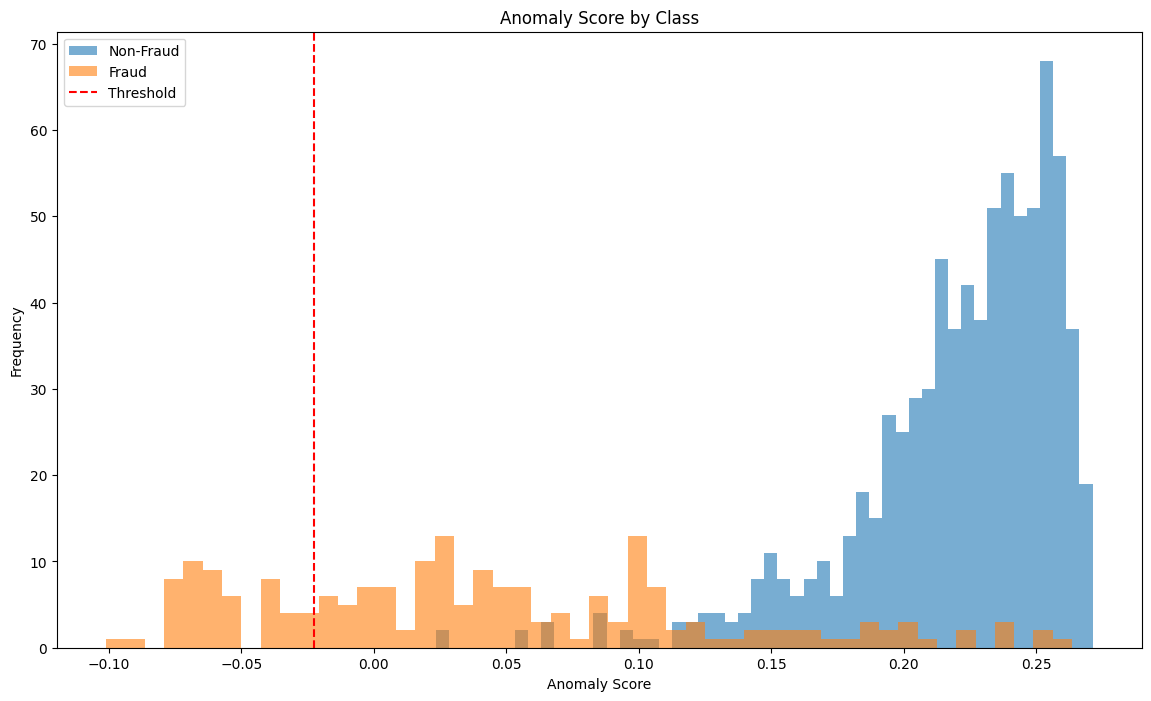

In [7]:
# Bước 11: Hiển thị các giao dịch mà mô hình đánh dấu là gian lận và so sánh với nhãn thực tế
results_df = pd.DataFrame({
    'anomaly_score': anomaly_scores,
    'predicted_anomaly': y_pred_test_adjusted,
    'actual_label': y_test.values  # Nhãn thực tế từ dữ liệu
})

# Hiển thị các giao dịch mà mô hình đánh dấu là gian lận
fraud_cases = results_df[results_df['predicted_anomaly'] == 1]
print(fraud_cases.head())  # Hiển thị một số giao dịch bị dự đoán là gian lận

# Bước 12: Vẽ biểu đồ phân phối điểm bất thường theo nhãn
plt.figure(figsize=(14, 8))
plt.hist(anomaly_scores[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud')
plt.hist(anomaly_scores[y_test == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Score by Class')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()
